# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
# pip install catboost

In [7]:
# conda install lightgbm

In [7]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [8]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(96397, 27)
CPU times: user 311 ms, sys: 56.2 ms, total: 367 ms
Wall time: 379 ms


,cardnum_merchnum_merchstate_total_14,cardnum_zip3_max_14,cardnum_merchnum_merchzip_avg_14,cardnum_merchnum_merchdes_avg_7,Merch_description_max_0,cardnum_merchnum_avg_14,cardnum_merchnum_merchdes_total_14,Merch_zip_max_0,cardnum_merchnum_avg_7,cardnum_merchnum_merchstate_avg_7,...,cardnum_merchnum_merchzip_avg_30,cardnum_merchnum_merchstate_avg_30,cardnum_merchnum_zip3_avg_30,merchnum_merchdes_max_0,merchnum_zip3_max_0,merchnum_merchstate_max_0,Merchnum_max_0,merchnum_merchzip_max_0,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1.0,0.0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2.0,0.0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3.0,0.0
3,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,4.0,0.0
4,7.24,3.62,3.62,3.62,3.62,3.62,7.24,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,5.0,0.0


In [9]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 20

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'cardnum_merchnum_merchstate_total_14',
 'cardnum_zip3_max_14',
 'cardnum_merchnum_merchzip_avg_14',
 'cardnum_merchnum_merchdes_avg_7',
 'Merch_description_max_0',
 'cardnum_merchnum_avg_14',
 'cardnum_merchnum_merchdes_total_14',
 'Merch_zip_max_0',
 'cardnum_merchnum_avg_7',
 'cardnum_merchnum_merchstate_avg_7',
 'cardnum_merchnum_zip3_avg_14',
 'cardnum_merchnum_merchstate_avg_14',
 'cardnum_merchnum_merchdes_avg_14',
 'cardnum_merchnum_zip3_avg_7',
 'cardnum_merchnum_merchzip_avg_7',
 'cardnum_merchdes_avg_7',
 'cardnum_merchnum_avg_30',
 'cardnum_merchnum_merchzip_avg_30',
 'cardnum_merchnum_merchstate_avg_30',
 'cardnum_merchnum_zip3_avg_30']

In [10]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,cardnum_merchnum_merchstate_total_14,cardnum_zip3_max_14,cardnum_merchnum_merchzip_avg_14,cardnum_merchnum_merchdes_avg_7,Merch_description_max_0,cardnum_merchnum_avg_14,cardnum_merchnum_merchdes_total_14,Merch_zip_max_0,...,cardnum_merchnum_zip3_avg_14,cardnum_merchnum_merchstate_avg_14,cardnum_merchnum_merchdes_avg_14,cardnum_merchnum_zip3_avg_7,cardnum_merchnum_merchzip_avg_7,cardnum_merchdes_avg_7,cardnum_merchnum_avg_30,cardnum_merchnum_merchzip_avg_30,cardnum_merchnum_merchstate_avg_30,cardnum_merchnum_zip3_avg_30
0,1.0,0.0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2.0,0.0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3.0,0.0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4.0,0.0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5.0,0.0,7.24,3.62,3.62,3.62,3.62,3.62,7.24,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [11]:
vars.shape

(96397, 22)

In [12]:
vars['Fraud'].sum()

1059.0

In [13]:
vars.head(10)

,Recnum,Fraud,cardnum_merchnum_merchstate_total_14,cardnum_zip3_max_14,cardnum_merchnum_merchzip_avg_14,cardnum_merchnum_merchdes_avg_7,Merch_description_max_0,cardnum_merchnum_avg_14,cardnum_merchnum_merchdes_total_14,Merch_zip_max_0,...,cardnum_merchnum_zip3_avg_14,cardnum_merchnum_merchstate_avg_14,cardnum_merchnum_merchdes_avg_14,cardnum_merchnum_zip3_avg_7,cardnum_merchnum_merchzip_avg_7,cardnum_merchdes_avg_7,cardnum_merchnum_avg_30,cardnum_merchnum_merchzip_avg_30,cardnum_merchnum_merchstate_avg_30,cardnum_merchnum_zip3_avg_30
0,1.0,0.0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2.0,0.0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3.0,0.0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4.0,0.0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5.0,0.0,7.24,3.62,3.62,3.62,3.62,3.62,7.24,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
5,6.0,0.0,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,...,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67
6,7.0,0.0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.67,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
7,8.0,0.0,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,...,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9.0,0.0,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,...,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10.0,0.0,10.86,3.62,3.62,3.62,3.62,3.62,10.86,3.67,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [14]:
vars.shape

(96397, 22)

In [15]:
vars.describe()

,Recnum,Fraud,cardnum_merchnum_merchstate_total_14,cardnum_zip3_max_14,cardnum_merchnum_merchzip_avg_14,cardnum_merchnum_merchdes_avg_7,Merch_description_max_0,cardnum_merchnum_avg_14,cardnum_merchnum_merchdes_total_14,Merch_zip_max_0,...,cardnum_merchnum_zip3_avg_14,cardnum_merchnum_merchstate_avg_14,cardnum_merchnum_merchdes_avg_14,cardnum_merchnum_zip3_avg_7,cardnum_merchnum_merchzip_avg_7,cardnum_merchdes_avg_7,cardnum_merchnum_avg_30,cardnum_merchnum_merchzip_avg_30,cardnum_merchnum_merchstate_avg_30,cardnum_merchnum_zip3_avg_30
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,...,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,769.916878,529.353162,401.896497,399.833630,500.666148,401.927811,747.947017,559.777788,...,401.924962,401.935497,401.856160,399.917152,399.910465,399.910887,403.981284,403.960462,403.995420,403.997926
std,27945.003883,0.104236,4168.200978,1086.568630,790.475425,793.316401,1013.733647,790.425618,4158.952270,1075.408746,...,790.475956,790.435211,790.554357,793.254163,793.244407,790.515295,784.742036,784.823250,784.753332,784.798539
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,24154.000000,0.000000,77.000000,57.190000,39.990000,38.450000,47.690000,39.990000,55.770000,65.520000,...,39.990000,39.990000,39.990000,38.360000,38.360000,39.010000,42.280000,42.270000,42.280000,42.280000
50%,48365.000000,0.000000,236.890000,212.660000,157.000000,150.275000,190.000000,157.065000,205.410000,227.210000,...,157.000000,157.040000,157.000000,150.270000,150.270000,151.470000,165.000000,165.000000,165.000000,165.000000
75%,72578.000000,0.000000,676.860000,609.000000,452.800000,447.220000,575.990000,452.940000,655.000000,667.210000,...,452.940000,452.940000,452.500000,447.385000,447.400000,448.000000,463.100000,463.000000,463.190000,463.180000
max,96753.000000,1.000000,306633.410000,47900.000000,28392.840000,28392.840000,47900.000000,28392.840000,306633.410000,47900.000000,...,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000


In [16]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [17]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,cardnum_merchnum_merchstate_total_14,cardnum_zip3_max_14,cardnum_merchnum_merchzip_avg_14,cardnum_merchnum_merchdes_avg_7,Merch_description_max_0,cardnum_merchnum_avg_14,cardnum_merchnum_merchdes_total_14,Merch_zip_max_0,cardnum_merchnum_avg_7,cardnum_merchnum_merchstate_avg_7,cardnum_merchnum_zip3_avg_14,cardnum_merchnum_merchstate_avg_14,cardnum_merchnum_merchdes_avg_14,cardnum_merchnum_zip3_avg_7,cardnum_merchnum_merchzip_avg_7,cardnum_merchdes_avg_7,cardnum_merchnum_avg_30,cardnum_merchnum_merchzip_avg_30,cardnum_merchnum_merchstate_avg_30,cardnum_merchnum_zip3_avg_30
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,769.916878,529.353162,401.896497,399.833630,500.666148,401.927811,747.947017,559.777788,399.930390,399.932838,401.924962,401.935497,401.856160,399.917152,399.910465,399.910887,403.981284,403.960462,403.995420,403.997926
std,4168.200978,1086.568630,790.475425,793.316401,1013.733647,790.425618,4158.952270,1075.408746,793.236155,793.239219,790.475956,790.435211,790.554357,793.254163,793.244407,790.515295,784.742036,784.823250,784.753332,784.798539
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,77.000000,57.190000,39.990000,38.450000,47.690000,39.990000,55.770000,65.520000,38.360000,38.360000,39.990000,39.990000,39.990000,38.360000,38.360000,39.010000,42.280000,42.270000,42.280000,42.280000
50%,236.890000,212.660000,157.000000,150.275000,190.000000,157.065000,205.410000,227.210000,150.330000,150.315000,157.000000,157.040000,157.000000,150.270000,150.270000,151.470000,165.000000,165.000000,165.000000,165.000000
75%,676.860000,609.000000,452.800000,447.220000,575.990000,452.940000,655.000000,667.210000,447.400000,447.400000,452.940000,452.940000,452.500000,447.385000,447.400000,448.000000,463.100000,463.000000,463.190000,463.180000
max,306633.410000,47900.000000,28392.840000,28392.840000,47900.000000,28392.840000,306633.410000,47900.000000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000


In [18]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [19]:
# use this to cap variables. For some problems it helps
Clip = 10

In [20]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,cardnum_merchnum_merchstate_total_14,cardnum_zip3_max_14,cardnum_merchnum_merchzip_avg_14,cardnum_merchnum_merchdes_avg_7,Merch_description_max_0,cardnum_merchnum_avg_14,cardnum_merchnum_merchdes_total_14,Merch_zip_max_0,cardnum_merchnum_avg_7,cardnum_merchnum_merchstate_avg_7,cardnum_merchnum_zip3_avg_14,cardnum_merchnum_merchstate_avg_14,cardnum_merchnum_merchdes_avg_14,cardnum_merchnum_zip3_avg_7,cardnum_merchnum_merchzip_avg_7,cardnum_merchdes_avg_7,cardnum_merchnum_avg_30,cardnum_merchnum_merchzip_avg_30,cardnum_merchnum_merchstate_avg_30,cardnum_merchnum_zip3_avg_30
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-3.879285e-16,1.642357e-15,9.988873e-15,3.080757e-15,-1.068991e-15,9.159462e-15,-1.695628e-15,1.732038e-15,1.109360e-14,1.012894e-14,9.559347e-15,9.566574e-15,2.054227e-15,1.194135e-14,1.102295e-14,3.422300e-15,9.755010e-15,9.971516e-15,9.802164e-15,9.587037e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.847096e-01,-4.871696e-01,-5.084111e-01,-5.039901e-01,-4.938735e-01,-5.084828e-01,-1.798378e-01,-5.205163e-01,-5.041631e-01,-5.041642e-01,-5.084468e-01,-5.084863e-01,-5.083093e-01,-5.041350e-01,-5.041327e-01,-5.058737e-01,-5.147823e-01,-5.147025e-01,-5.147929e-01,-5.147664e-01
25%,-1.662388e-01,-4.345452e-01,-4.578340e-01,-4.555353e-01,-4.468394e-01,-4.579024e-01,-1.664306e-01,-4.595999e-01,-4.558168e-01,-4.558182e-01,-4.578697e-01,-4.579066e-01,-4.577372e-01,-4.557898e-01,-4.557870e-01,-4.565388e-01,-4.609174e-01,-4.608559e-01,-4.609288e-01,-4.609055e-01
50%,-1.278794e-01,-2.914617e-01,-3.098091e-01,-3.145764e-01,-3.064574e-01,-3.097860e-01,-1.304504e-01,-3.092478e-01,-3.146609e-01,-3.146817e-01,-3.098449e-01,-3.098236e-01,-3.097272e-01,-3.147127e-01,-3.147081e-01,-3.142771e-01,-3.045348e-01,-3.044768e-01,-3.045485e-01,-3.045341e-01
75%,-2.232543e-02,7.330125e-02,6.439606e-02,5.973199e-02,7.430340e-02,6.453762e-02,-2.234866e-02,9.989896e-02,5.984297e-02,5.983966e-02,6.453712e-02,6.452711e-02,6.406117e-02,5.983939e-02,5.986747e-02,6.083262e-02,7.533522e-02,7.522654e-02,7.543081e-02,7.541053e-02
max,7.338022e+01,4.359655e+01,3.541026e+01,3.528606e+01,4.675719e+01,3.541246e+01,7.354868e+01,4.402068e+01,3.528950e+01,3.528936e+01,3.541020e+01,3.541202e+01,3.540678e+01,3.528872e+01,3.528916e+01,3.541099e+01,3.566632e+01,3.566265e+01,3.566579e+01,3.566373e+01


In [21]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=84300
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

In [22]:
X_oot = X[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [23]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [24]:
alphas = 10**np.linspace(2,9,30)*0.5

In [25]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [26]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 20)

CPU times: user 682 ms, sys: 139 ms, total: 821 ms
Wall time: 742 ms


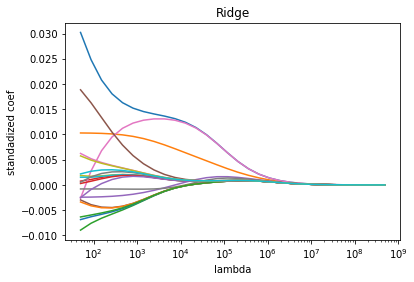

In [27]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [28]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [29]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
CPU times: user 26.2 s, sys: 794 ms, total: 27 s
Wall time: 6.8 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


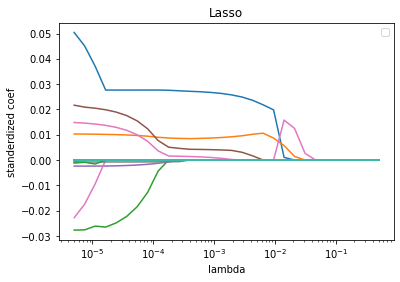

In [30]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [31]:
len(X_trntst.columns)

20

In [32]:
X_trntst_save = X_trntst.copy()

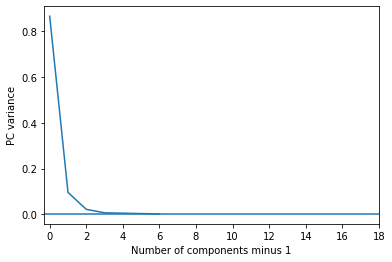

In [33]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [34]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-2.155730,0.099880,-0.118288,-0.048041,-0.020584,-0.023354
1,-2.012959,0.080973,-0.119141,-0.049272,-0.019220,-0.023163
2,-1.257659,-0.019053,-0.123653,-0.055784,-0.012004,-0.022149
3,-2.155730,0.099880,-0.118288,-0.048041,-0.020584,-0.023354
4,-2.155505,0.101002,-0.118620,-0.048338,-0.020526,-0.023333


In [35]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
84300,-1.457978,0.010958,-0.122695,-0.040517,-0.017542,-0.021077
84301,-1.746763,0.222274,0.557882,-0.027023,0.100117,0.517037
84302,8.315807,-1.261666,-0.067388,-0.150644,0.103335,0.079101
84303,-1.076136,0.015960,0.140917,-0.086201,0.045624,0.185078
84304,0.934853,-0.309412,-0.136753,-0.074686,0.008944,-0.019207


In [36]:
X_trntst.describe()

,cardnum_merchnum_merchstate_total_14,cardnum_zip3_max_14,cardnum_merchnum_merchzip_avg_14,cardnum_merchnum_merchdes_avg_7,Merch_description_max_0,cardnum_merchnum_avg_14,cardnum_merchnum_merchdes_total_14,Merch_zip_max_0,cardnum_merchnum_avg_7,cardnum_merchnum_merchstate_avg_7,cardnum_merchnum_zip3_avg_14,cardnum_merchnum_merchstate_avg_14,cardnum_merchnum_merchdes_avg_14,cardnum_merchnum_zip3_avg_7,cardnum_merchnum_merchzip_avg_7,cardnum_merchdes_avg_7,cardnum_merchnum_avg_30,cardnum_merchnum_merchzip_avg_30,cardnum_merchnum_merchstate_avg_30,cardnum_merchnum_zip3_avg_30
count,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000
mean,0.002826,0.001721,0.002947,0.003180,0.004370,0.002939,0.002972,0.004240,0.003167,0.003167,0.002952,0.002936,0.002958,0.003182,0.003181,0.003139,0.002609,0.002618,0.002607,0.002625
std,1.056881,1.009334,0.998360,0.999489,1.009885,0.998358,1.059457,1.009224,0.999488,0.999488,0.998360,0.998351,0.998368,0.999493,0.999491,0.999237,0.995586,0.995594,0.995579,0.995589
min,-0.184710,-0.487170,-0.508411,-0.503990,-0.493873,-0.508483,-0.179838,-0.520516,-0.504163,-0.504164,-0.508447,-0.508486,-0.508309,-0.504135,-0.504133,-0.505874,-0.514782,-0.514702,-0.514793,-0.514766
25%,-0.166287,-0.436708,-0.459896,-0.458097,-0.448874,-0.459965,-0.166856,-0.460223,-0.458351,-0.458352,-0.459913,-0.459969,-0.459701,-0.458324,-0.458337,-0.459088,-0.463823,-0.463748,-0.463834,-0.463811
50%,-0.127629,-0.292962,-0.309711,-0.314400,-0.307030,-0.309552,-0.130918,-0.308099,-0.314447,-0.314466,-0.309626,-0.309574,-0.309629,-0.314496,-0.314492,-0.314163,-0.304535,-0.304509,-0.304548,-0.304534
75%,-0.022086,0.074590,0.067179,0.063126,0.079544,0.067163,-0.022900,0.105050,0.063062,0.063059,0.067219,0.067209,0.067224,0.063093,0.063110,0.063363,0.078989,0.078778,0.079012,0.079004
max,73.380217,43.596553,35.410264,35.286055,46.757187,35.412456,73.548683,44.020678,35.289503,35.289364,35.410204,35.412016,35.406780,35.288719,35.289161,35.410990,35.666318,35.662653,35.665786,35.663729


In [37]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000
mean,-0.106267,-0.015293,-0.014347,0.013551,0.002443,0.002037
std,4.129011,0.671866,0.636887,0.447093,0.336413,0.247348
min,-2.174270,-18.409307,-6.648707,-3.187600,-5.703180,-5.390845
25%,-1.851289,-0.106190,-0.137283,-0.073912,-0.019880,-0.023207
50%,-1.270086,0.052013,-0.121741,-0.053712,-0.011779,-0.021348
75%,0.173335,0.113989,-0.084425,-0.038150,0.019154,-0.009622
max,137.607824,13.882510,28.450979,21.355424,20.543550,12.758858


In [38]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [39]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04
mean,4.687485e-16,2.396738e-16,1.339623e-16,-3.420224e-17,-1.372568e-17,1.980361e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.192270e-01,-1.379751e+01,-2.540129e+01,-2.174458e+01,-4.918845e+01,-2.182316e+01
25%,-4.580073e-01,-7.304371e-02,-2.060269e-01,-2.084357e-01,-6.349742e-02,-9.324817e-02
50%,-3.011421e-01,4.348519e-02,-1.831736e-01,-1.491359e-01,-3.605010e-02,-8.440316e-02
75%,6.897320e-02,8.860177e-02,-1.091298e-01,-1.118569e-01,6.931552e-02,-3.161074e-02
max,3.433346e+01,6.834541e+01,5.033193e+01,6.073104e+01,6.017010e+01,1.046348e+02


In [40]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000
mean,-0.025377,-0.010985,-0.021689,0.037370,0.007854,0.008179
std,0.986029,0.482607,0.962841,1.233007,1.081780,0.993010
min,-0.519227,-13.223556,-10.051464,-8.790863,-18.339310,-21.642279
25%,-0.442097,-0.076277,-0.207543,-0.203837,-0.063926,-0.093168
50%,-0.303303,0.037361,-0.184047,-0.148129,-0.037876,-0.085706
75%,0.041393,0.081879,-0.127633,-0.105211,0.061591,-0.038630
max,32.861473,9.971921,43.011970,58.894648,66.060428,51.222170


In [41]:
X_trntst_pca.shape

(84300, 6)

In [42]:
X_oot_orig_pca.shape

(12097, 6)

## Subsample the larger class if desired

In [43]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.01043890865954923
(1751, 20) 1751


In [44]:
niter = 0
nitermax = 10
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [52]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [221]:
Modeling_output.to_csv('Modeling_output.csv')

In [208]:
Modeling_output

,Model,Trn,Tst,OOT
0,log reg,0.628981,0.626984,0.486034
1,log reg,0.625413,0.638686,0.497207
2,log reg,0.646281,0.621818,0.502793
3,log reg,0.623234,0.658436,0.50838
4,log reg,0.634615,0.625,0.49162
...,...,...,...,...
995,LGBM,0.789562,0.769231,0.502793
996,LGBM,0.789474,0.769231,0.50838
997,LGBM,0.805324,0.749104,0.418994
998,LGBM,0.786174,0.786822,0.49162


In [218]:
s = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000000))

In [219]:
Modeling_output= Modeling_output.append(s,ignore_index=True)

<ipython-input-219-d6cd07eaed3c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Modeling_output= Modeling_output.append(s,ignore_index=True)


In [42]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty='l1', C=1, solver='saga',l1_ratio=0.5)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


0 0.643879173290938 0.6135458167330677 0.41899441340782123


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1 0.6134185303514377 0.6811023622047244 0.441340782122905


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


2 0.6337115072933549 0.6387832699619772 0.40782122905027934


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


3 0.65 0.6125 0.5027932960893855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


4 0.6370967741935484 0.6384615384615384 0.5027932960893855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


5 0.6426282051282052 0.6328125 0.5027932960893855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


6 0.6483870967741936 0.6192307692307693 0.5027932960893855


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


7 0.6055194805194806 0.6856060606060606 0.45251396648044695


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


8 0.6370967741935484 0.6461538461538462 0.44692737430167595


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


9 0.6391096979332274 0.649402390438247 0.5083798882681564
trn    0.635085
tst    0.641760
oot    0.468715
dtype: float64
CPU times: user 1min 27s, sys: 2.83 s, total: 1min 30s
Wall time: 1min 45s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [50]:
nitermax=5

In [62]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=10,min_samples_split=50,min_samples_leaf=30)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.8293838862559242 0.7773279352226721 0.3575418994413408
1 0.8227642276422764 0.7735849056603774 0.329608938547486
2 0.826645264847512 0.754863813229572 0.3575418994413408
3 0.8186195826645265 0.7470817120622568 0.33519553072625696
4 0.838810641627543 0.7759336099585062 0.3407821229050279
5 0.8152350081037277 0.7072243346007605 0.3463687150837989
6 0.8375796178343949 0.7817460317460317 0.31843575418994413
7 0.8287112561174551 0.7303370786516854 0.36312849162011174
8 0.834658187599364 0.7330677290836654 0.35195530726256985
9 0.8622366288492707 0.7604562737642585 0.5363128491620112
trn    0.831464
tst    0.754162
oot    0.363687
dtype: float64
CPU times: user 15.5 s, sys: 110 ms, total: 15.7 s
Wall time: 15.7 s


In [70]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(criterion='entropy',n_estimators=100,max_depth=15,min_samples_split=30,min_samples_leaf=200,max_features='log2')
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.767479674796748 0.7396226415094339 0.5139664804469274
1 0.7344992050874404 0.7330677290836654 0.5307262569832403
2 0.7791798107255521 0.7276422764227642 0.5307262569832403
3 0.7552334943639292 0.752895752895753 0.5418994413407822
4 0.753125 0.7458333333333333 0.5251396648044693
5 0.7642276422764228 0.7396226415094339 0.5363128491620112
6 0.7237048665620094 0.7037037037037037 0.5139664804469274
7 0.7460567823343849 0.7520325203252033 0.5307262569832403
8 0.7575757575757576 0.7193675889328063 0.547486033519553
9 0.7662337662337663 0.7575757575757576 0.5363128491620112
trn    0.754732
tst    0.737136
oot    0.530726
dtype: float64
CPU times: user 4min 45s, sys: 1.65 s, total: 4min 47s
Wall time: 4min 54s


In [204]:
Modeling_output

,Model,Trn,Tst,OOT
0,log reg,0.628981,0.626984,0.486034
1,log reg,0.625413,0.638686,0.497207
2,log reg,0.646281,0.621818,0.502793
3,log reg,0.623234,0.658436,0.50838
4,log reg,0.634615,0.625,0.49162
...,...,...,...,...
995,LGBM,0.789562,0.769231,0.502793
996,LGBM,0.789474,0.769231,0.50838
997,LGBM,0.805324,0.749104,0.418994
998,LGBM,0.786174,0.786822,0.49162


In [210]:
%%time
# LGBM
#,min_child_samples=10
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
#,min_child_samples=10
    model = lgb.LGBMClassifier(n_estimators=50,num_leaves=10,max_depth=15,learning_rate=0.03,boosting_type='gbdt',min_child_weight=0.001,min_child_samples=25)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7946287519747235 0.805668016194332 0.5083798882681564
1 0.7751196172248804 0.7707509881422925 0.5307262569832403
2 0.7921259842519685 0.763265306122449 0.3854748603351955
3 0.7852459016393443 0.725925925925926 0.5027932960893855
4 0.803486529318542 0.7429718875502008 0.41899441340782123
5 0.7763371150729336 0.7908745247148289 0.3463687150837989
6 0.8111658456486043 0.7416974169741697 0.5363128491620112
7 0.8074433656957929 0.7251908396946565 0.39106145251396646
8 0.7873376623376623 0.75 0.5418994413407822
9 0.8055555555555556 0.746268656716418 0.4692737430167598
trn    0.793845
tst    0.756261
oot    0.463128
dtype: float64
CPU times: user 20.7 s, sys: 1.89 s, total: 22.6 s
Wall time: 4.65 s


0 0.8841059602649006 0.8188405797101449 0.41899441340782123
1 0.8820678513731826 0.8160919540229885 0.3575418994413408
2 0.8870431893687708 0.7949640287769785 0.48044692737430167
3 0.8858520900321544 0.810077519379845 0.3743016759776536
4 0.867862969004894 0.7865168539325843 0.3743016759776536
5 0.8724409448818897 0.7551020408163265 0.3463687150837989
6 0.8710743801652893 0.8036363636363636 0.40782122905027934
7 0.8710743801652893 0.8254545454545454 0.3575418994413408
8 0.8912 0.8 0.4581005586592179
9 0.8676236044657097 0.7984189723320159 0.41899441340782123
loop trn tst oot 1 0.8780345369722081 0.8009102858061793 0.39944134078212296
0 0.8757763975155279 0.7966101694915254 0.441340782122905
1 0.8916797488226059 0.7860082304526749 0.44692737430167595
2 0.8708133971291866 0.8458498023715415 0.35195530726256985
3 0.8866141732283465 0.8163265306122449 0.35195530726256985
4 0.8758064516129033 0.8076923076923077 0.3575418994413408
5 0.8637083993660856 0.8353413654618473 0.41899441340782123
6

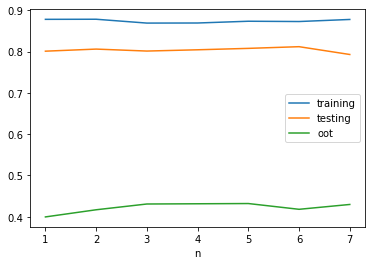

In [220]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,8):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = lgb.LGBMClassifier(n_estimators=200,num_leaves=10,max_depth=20,learning_rate=0.03,boosting_type='gbdt',min_child_weight=0.001,min_child_samples=10)
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_YOUR MODEL NAME.pdf', format='pdf')
plt.show()


In [43]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5731329038415652 0.5649655172413793 0.548197820620285
1 0.5792356232884868 0.5698447893569845 0.5532271584241408
2 0.5774496963924277 0.573170731707317 0.5490360435875943
3 0.5815198002140564 0.5825458588104503 0.5565800502933781
4 0.5558478832815116 0.5665294924554184 0.5322715842414082
trn    0.573437
tst    0.571411
oot    0.547863
dtype: float64
CPU times: user 1min 14s, sys: 768 ms, total: 1min 15s
Wall time: 1min 10s


In [73]:
%%time
# NN on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(5,5),activation='relu',alpha=0.001,learning_rate='constant',learning_rate_init=0.001,solver='adam',max_iter=100)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6650406504065041 0.6037735849056604 0.39664804469273746
1 0.6962025316455697 0.6653225806451613 0.5195530726256983
2 0.6414473684210527 0.6948529411764706 0.5251396648044693
3 0.703150912106136 0.6498194945848376 0.5139664804469274
4 0.6905537459283387 0.6766917293233082 0.5083798882681564
5 0.687402799377916 0.6666666666666666 0.5195530726256983
6 0.66 0.7035714285714286 0.5139664804469274
7 0.6698564593301436 0.6679841897233202 0.5195530726256983
8 0.6593406593406593 0.6954732510288066 0.5251396648044693
9 0.6505016722408027 0.7127659574468085 0.4860335195530726
trn    0.672350
tst    0.673692
oot    0.502793
dtype: float64
CPU times: user 1min 42s, sys: 3.42 s, total: 1min 45s
Wall time: 1min 59s


In [45]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=2,n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5909364106262772 0.591648590021692 0.567476948868399
1 0.5938643067846607 0.5838052095130238 0.5678960603520536
2 0.5898622981956315 0.5900083728718951 0.5611902766135792
3 0.598698224852071 0.5892606128760192 0.5708298407376362
4 0.5997116770783277 0.5875644854737986 0.5704107292539815
trn    0.594615
tst    0.588457
oot    0.567561
dtype: float64
CPU times: user 5.67 s, sys: 760 ms, total: 6.43 s
Wall time: 5.98 s


In [91]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(bootstrap_type='Bayesian',verbose=0, max_depth=7, iterations=500,l2_leaf_reg=15,learning_rate=0.01,random_state=4)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7323717948717948 0.7421875 0.45251396648044695
1 0.7244732576985413 0.7452471482889734 0.5027932960893855
2 0.7342995169082126 0.7297297297297297 0.5251396648044693
3 0.7269681742043551 0.734982332155477 0.5307262569832403
4 0.7437888198757764 0.7457627118644068 0.5195530726256983
5 0.7428571428571429 0.724 0.5307262569832403
6 0.7269736842105263 0.7647058823529411 0.5307262569832403
7 0.7398373983739838 0.7245283018867924 0.4301675977653631
8 0.7539936102236422 0.7047244094488189 0.5083798882681564
9 0.7394695787831513 0.7615062761506276 0.4972067039106145
trn    0.736503
tst    0.737737
oot    0.502793
dtype: float64
CPU times: user 4min 13s, sys: 5.45 s, total: 4min 18s
Wall time: 44.6 s


In [47]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

68.41842258682435
0 0.5964853835262763 0.5964853835262763 0.5716680637049455
1 0.5957358207712168 0.5957358207712168 0.5720871751886002
2 0.5964020987757142 0.5964020987757142 0.5716680637049455
3 0.5960689597734655 0.5960689597734655 0.5720871751886002
4 0.5959856750229033 0.5959856750229033 0.5704107292539815
trn    0.596136
tst    0.596136
oot    0.571584
dtype: float64
CPU times: user 2.57 s, sys: 596 ms, total: 3.17 s
Wall time: 2.67 s


In [48]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5408685306365258 0.5399777901166019 0.5134115674769488
1 0.5399881164587047 0.5473273942093542 0.5134115674769488
2 0.5566714490674318 0.5479000823497118 0.5272422464375524
3 0.5439153439153439 0.5405482581382067 0.5142497904442582
4 0.5694162588038677 0.5589531680440771 0.5393964794635373
trn    0.550172
tst    0.546941
oot    0.521542
dtype: float64
CPU times: user 4.67 s, sys: 306 ms, total: 4.98 s
Wall time: 2.43 s


In [49]:
%%time
# unsupervised model using pc's. 

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    pow = 2
    oop = 1/pow
    predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5559905100830368 0.5457086944366788 0.519279128248114
1 0.5557547508067407 0.5464285714285714 0.519279128248114
2 0.5499702911467618 0.5601336302895323 0.519279128248114
3 0.5525876460767947 0.5526097763048882 0.519279128248114
4 0.5505590958278226 0.5582655826558266 0.519279128248114
trn    0.552972
tst    0.552629
oot    0.519279
dtype: float64
CPU times: user 1.53 s, sys: 246 ms, total: 1.77 s
Wall time: 1.77 s


In [96]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    #,num_leaves=50,learning_rate=0.1
    model = xgb.XGBClassifier(booster='dart',max_depth=7,tree_method='auto',min_child_weight=200,colsample_bytree=1,n_estimators=300)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[09:23:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

0 0.6557911908646004 0.6254681647940075 0.3854748603351955
[09:23:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

1 0.6581875993640699 0.6135458167330677 0.4022346368715084
[09:23:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

2 0.6446700507614214 0.6643598615916955 0.3743016759776536
[09:23:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

3 0.6645264847512039 0.6653696498054474 0.3743016759776536
[09:23:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

4 0.6323777403035413 0.6829268292682927 0.3687150837988827
[09:24:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

5 0.6430921052631579 0.6470588235294118 0.40782122905027934
[09:24:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

6 0.6613162118780096 0.6381322957198443 0.3687150837988827
[09:24:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

7 0.6509433962264151 0.6885245901639344 0.39664804469273746
[09:24:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python

8 0.6513157894736842 0.6507352941176471 0.37988826815642457
[09:24:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9 0.6633986928104575 0.6455223880597015 0.39664804469273746
trn    0.652562
tst    0.652164
oot    0.385475
dtype: float64
CPU times: user 10min 16s, sys: 9.75 s, total: 10min 26s
Wall time: 1min 28s


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [51]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [52]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [65]:
df1 = Modeling_output

In [67]:
df1.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.628981,0.626984,0.486034
1,log reg,0.625413,0.638686,0.497207
2,log reg,0.646281,0.621818,0.502793
3,log reg,0.623234,0.658436,0.50838
4,log reg,0.634615,0.625,0.49162
5,log reg,0.638095,0.596,0.469274
6,log reg,0.637705,0.6,0.497207
7,log reg,0.637417,0.619565,0.502793
8,log reg,0.641667,0.6,0.49162
9,log reg,0.63434,0.633466,0.49162


In [259]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.628981,0.626984,0.486034
1,log reg,0.625413,0.638686,0.497207
2,log reg,0.646281,0.621818,0.502793
3,log reg,0.623234,0.658436,0.50838
4,log reg,0.634615,0.625,0.49162
5,log reg,0.638095,0.596,0.469274
6,log reg,0.637705,0.6,0.497207
7,log reg,0.637417,0.619565,0.502793
8,log reg,0.641667,0.6,0.49162
9,log reg,0.63434,0.633466,0.49162


In [260]:
df.shape

(1010, 4)

In [261]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.628981
1,log reg,Trn,0.625413
2,log reg,Trn,0.646281
3,log reg,Trn,0.623234
4,log reg,Trn,0.634615


In [262]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.628981
1,log reg,Trn,0.625413
2,log reg,Trn,0.646281
3,log reg,Trn,0.623234
4,log reg,Trn,0.634615


In [263]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.643312  0.069814  0.629830  0.060804  0.369068  0.089139
LGBM       0.824889  0.055491  0.776958  0.035335  0.403914  0.064907
NN_PCs     0.665926  0.032272  0.661189  0.044101  0.470577  0.060289
RF         0.729111  0.040548  0.712675  0.039696  0.494134  0.055289
XGB        0.732082  0.093116  0.709580  0.070481  0.434413  0.058490
cat boost  0.769309  0.063777  0.746647  0.045978  0.443000  0.056822
log reg    0.638357  0.011841  0.623949  0.025961  0.483613  0.031249

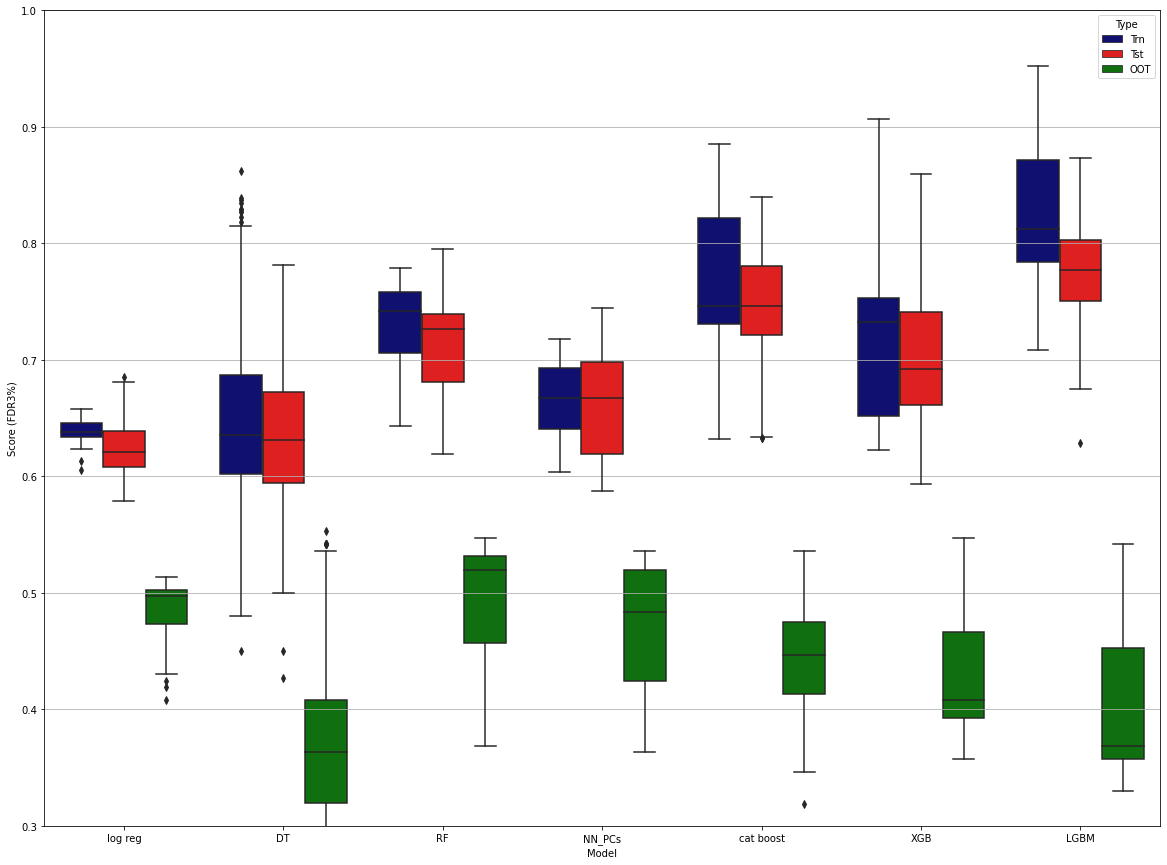

In [267]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))

ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.3,1)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [59]:
print('duration: ', datetime.now() - start_time)

duration:  0:05:33.669446


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [53]:
%%time
FDR3 = pd.DataFrame(np.zeros((20,3)), columns=('trn', 'tst', 'oot'))

for niter in range(20):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = RandomForestClassifier(criterion='gini',n_estimators=100,max_depth=15,min_samples_split=20,
                                  min_samples_leaf=200,max_features='log2')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7611940298507462 0.7184115523465704 0.5363128491620112
1 0.7627986348122867 0.7108843537414966 0.5251396648044693
2 0.7361769352290679 0.7408906882591093 0.5195530726256983
3 0.774247491638796 0.7588652482269503 0.5307262569832403
4 0.7673267326732673 0.7335766423357665 0.5027932960893855
5 0.7633333333333333 0.7464285714285714 0.5027932960893855
6 0.757071547420965 0.7383512544802867 0.5307262569832403
7 0.7651757188498403 0.7480314960629921 0.5251396648044693
8 0.752411575562701 0.751937984496124 0.5363128491620112
9 0.7281399046104928 0.7410358565737052 0.5307262569832403
10 0.7751277683134583 0.7474402730375427 0.5195530726256983
11 0.755591054313099 0.6535433070866141 0.5251396648044693
12 0.7391304347826086 0.7142857142857143 0.5307262569832403
13 0.7652733118971061 0.7403100775193798 0.5083798882681564
14 0.7556270096463023 0.7054263565891473 0.5363128491620112
15 0.7422003284072249 0.6937269372693727 0.5251396648044693
16 0.7635467980295566 0.7232472324723247 0.536312849162

In [54]:
for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(criterion='gini',n_estimators=100,max_depth=15,min_samples_split=20,
                                  min_samples_leaf=200,max_features='log2')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7386363636363636 0.7234848484848485 0.5363128491620112
1 0.7361563517915309 0.7406015037593985 0.5027932960893855
2 0.7772357723577236 0.7283018867924528 0.5307262569832403
3 0.7581168831168831 0.7083333333333334 0.5195530726256983
4 0.7636363636363637 0.6618181818181819 0.5307262569832403
5 0.757527733755943 0.7188755020080321 0.5251396648044693
6 0.7313915857605178 0.683206106870229 0.5307262569832403
7 0.7724252491694352 0.7338129496402878 0.5307262569832403
8 0.7524271844660194 0.767175572519084 0.5083798882681564
9 0.7564516129032258 0.7461538461538462 0.5195530726256983
10 0.7585644371941273 0.7340823970037453 0.5363128491620112
11 0.7507987220447284 0.7677165354330708 0.5083798882681564
12 0.7379767827529021 0.6859205776173285 0.5363128491620112
13 0.7658862876254181 0.7021276595744681 0.5307262569832403
14 0.7770491803278688 0.7333333333333333 0.5251396648044693
15 0.7678275290215588 0.6967509025270758 0.5363128491620112
16 0.7716535433070866 0.726530612244898 0.51955307262

In [65]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [66]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,cardnum_merchnum_merchstate_total_14,cardnum_zip3_max_14,cardnum_merchnum_merchzip_avg_14,cardnum_merchnum_merchdes_avg_7,Merch_description_max_0,cardnum_merchnum_avg_14,cardnum_merchnum_merchdes_total_14,Merch_zip_max_0,cardnum_merchnum_avg_7,cardnum_merchnum_merchstate_avg_7,...,cardnum_merchnum_merchdes_avg_14,cardnum_merchnum_zip3_avg_7,cardnum_merchnum_merchzip_avg_7,cardnum_merchdes_avg_7,cardnum_merchnum_avg_30,cardnum_merchnum_merchzip_avg_30,cardnum_merchnum_merchstate_avg_30,cardnum_merchnum_zip3_avg_30,predicted,Fraud
89019,3.349890,13.071956,18.129638,18.067314,14.039451,18.130741,3.362622,13.179316,18.069020,18.068947,...,18.127879,18.068626,18.068857,18.131236,18.259438,18.257575,18.259157,18.258102,0.495963,0.0
88278,5.986535,21.154344,15.762164,15.708318,22.702545,15.763118,6.005131,21.345579,15.709785,15.709721,...,15.760642,15.709445,15.709647,15.763881,20.568142,20.566040,20.567828,20.566640,0.495963,0.0
89506,7.529647,21.154344,13.050927,7.603733,5.850979,13.051709,7.551674,5.460456,7.604381,7.604348,...,13.049675,7.604225,7.604327,7.630579,13.143621,13.142288,13.143414,13.142654,0.495963,0.0
95685,5.775893,22.378381,30.922028,30.813893,24.014527,30.923937,5.794020,22.582318,30.816888,30.816766,...,30.918992,30.816205,30.816592,30.922981,31.145291,31.142094,31.144824,31.143027,0.495963,0.0
89927,5.619471,21.778327,30.097208,29.992026,23.371360,30.099065,5.637250,21.976037,29.994938,29.994819,...,30.094254,29.994274,29.994651,30.098202,30.314444,30.311334,30.313990,30.312241,0.495963,0.0
89065,6.006292,23.262218,32.136930,32.024444,24.961866,32.138916,6.024932,23.475327,32.027561,32.027435,...,32.133772,32.026851,32.027253,32.137821,32.369069,32.365745,32.368585,32.366717,0.495963,1.0
87678,3.879152,15.102264,20.920452,20.848134,16.215634,20.921731,3.893061,15.230695,20.850121,20.850037,...,20.918415,20.849664,20.849929,20.921909,21.070642,21.068488,21.070321,21.069104,0.495963,0.0
95844,11.736498,22.378381,30.922028,30.813893,24.014527,30.923937,11.767880,22.582318,30.816888,30.816766,...,30.918992,30.816205,30.816592,30.922981,31.145291,31.142094,31.144824,31.143027,0.495963,0.0
86093,2.553400,10.016530,13.929723,13.882439,10.764498,13.930561,2.564361,10.092183,13.883721,13.883664,...,13.928383,13.883423,13.883602,13.931532,14.028838,14.027413,14.028618,14.027807,0.495963,0.0
89328,6.345203,24.562320,33.924019,33.805133,26.355378,33.926117,6.364596,24.788921,33.808431,33.808297,...,33.920683,33.807680,33.808104,33.924820,34.169214,34.165705,34.168704,34.166733,0.495963,0.0


In [2]:
import pandas as pd

In [67]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,121.0,68.0,53.0,56.198347,43.801653,121.0,68.0,53.0,0.570566,29.608939,29.038373,1.283019
2,2.0,121.0,109.0,12.0,90.082645,9.917355,242.0,177.0,65.0,1.485149,36.312849,34.827701,2.723077
3,3.0,121.0,92.0,29.0,76.033058,23.966942,363.0,269.0,94.0,2.257090,52.513966,50.256876,2.861702
4,4.0,121.0,117.0,4.0,96.694215,3.305785,484.0,386.0,98.0,3.238798,54.748603,51.509805,3.938776
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,121.0,121.0,0.0,100.000000,0.000000,11613.0,11434.0,179.0,95.938916,100.000000,4.061084,63.877095
97,97.0,121.0,121.0,0.0,100.000000,0.000000,11734.0,11555.0,179.0,96.954187,100.000000,3.045813,64.553073
98,98.0,121.0,121.0,0.0,100.000000,0.000000,11855.0,11676.0,179.0,97.969458,100.000000,2.030542,65.229050
99,99.0,121.0,121.0,0.0,100.000000,0.000000,11976.0,11797.0,179.0,98.984729,100.000000,1.015271,65.905028


Max possible savings: 19,332,000.0


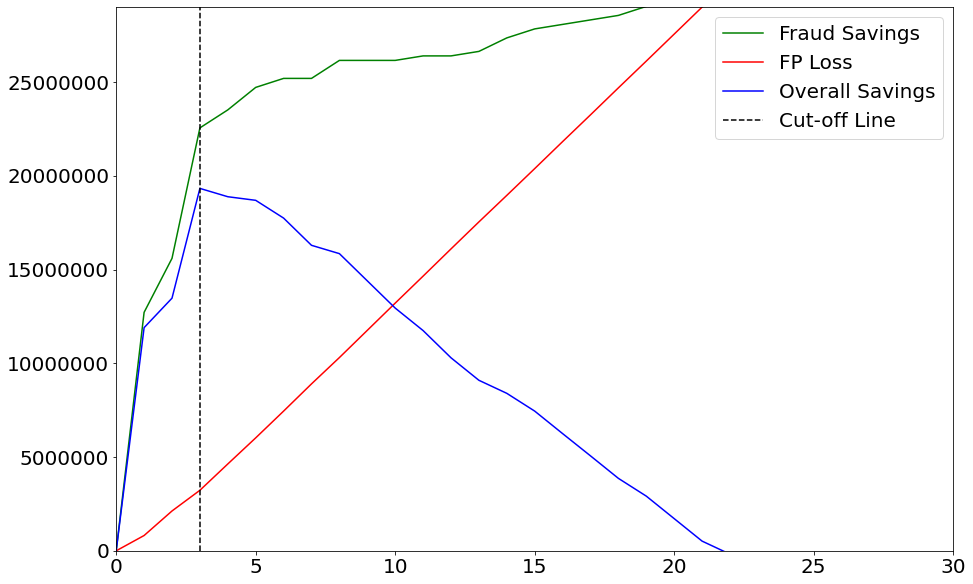

In [64]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
#xoot = 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss'] 

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green', label='Fraud Savings')
plt.plot(Financials_oot['FP Loss'], color='red', label='FP Loss')
plt.plot(Financials_oot['Overall Savings'], color='blue', label='Overall Savings')
plt.axvline(x=Financials_oot[Financials_oot['Overall Savings'] == max_savings].index, ls='--', label='Cut-off Line', color='black')
plt.legend(loc='best')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')


In [48]:
FDR3.to_csv('FDR3.csv')

In [68]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [66]:
print("duration: ", datetime.now() - start_time)

duration:  0:05:39.437525
